Troy Mazerolle

Student Number: 8972394

# Practical Lab 3 - Univariate Linear Regression 

In [1]:
# Utility Libraries
import pandas as pd
import numpy as np

# scikit-learn
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from scipy.stats import norm

# Plotting Libraries
import matplotlib.pyplot as plt

For this lab, we will be going over the Machine Learning Workflow using Univatiate Linear Regression as an example.  While some of the steps below may not be relevant or necessary for this lab in particular, I am still going to include them because I would at least like to discuss the point, why it is important, and potentially how it would be done in a more complex model.

## 1. Frame the problem and look at the big picture

[Here](https://scikit-learn.org/stable/datasets/toy_dataset.html#diabetes-dataset) is the description of the dataset we are loading in.  This is a diabetes dataset of n = 442 patients and their various bodily measurments, including body mass index, blood pressure, and various biochemical measurements.  The target variable we are trying to measure against is the measure of disease progression one year after the baseline.

It is important to recall that from the data description, "each of these 10 feature variables have been mean centered and scaled by the standard deviation times the square root of n_samples (i.e. the sum of squares of each column totals 1)".  This means that BMI was normallized, and 0 BMI or a one-unit change in BMI should NOT be interpreted as features of absolute BMI, but rather features of normalized BMI.

Therefore, the correct interpretation is as follows:
* The slope represents the change in disease progression with a unit-change in *standard deviation* in BMI
* The y-intercept represents the change in disease progression with an *average* BMI

## 2. Get the data

In [2]:
diabetes = datasets.load_diabetes()
y_colname = "disease_prog"
diabetes_X = pd.DataFrame(diabetes['data'], columns = diabetes['feature_names'])
diabetes_y = pd.DataFrame(diabetes['target'], columns = [y_colname])

print(pd.DataFrame.head(diabetes_X))
print(pd.DataFrame.head(diabetes_y))

        age       sex       bmi        bp        s1        s2        s3   
0  0.038076  0.050680  0.061696  0.021872 -0.044223 -0.034821 -0.043401  \
1 -0.001882 -0.044642 -0.051474 -0.026328 -0.008449 -0.019163  0.074412   
2  0.085299  0.050680  0.044451 -0.005670 -0.045599 -0.034194 -0.032356   
3 -0.089063 -0.044642 -0.011595 -0.036656  0.012191  0.024991 -0.036038   
4  0.005383 -0.044642 -0.036385  0.021872  0.003935  0.015596  0.008142   

         s4        s5        s6  
0 -0.002592  0.019907 -0.017646  
1 -0.039493 -0.068332 -0.092204  
2 -0.002592  0.002861 -0.025930  
3  0.034309  0.022688 -0.009362  
4 -0.002592 -0.031988 -0.046641  
   disease_prog
0         151.0
1          75.0
2         141.0
3         206.0
4         135.0


Above we can see the first five rows of the data.  Next, we move on to exploring the data in more detail.

## 3. Explore the data to gain insights

For this part, I will create a new dataframe that includes both the x and y variables so that they can be analyzed together.

I want to start with just a high-level summary of the data.  Using the .describe() method, we can see the count, average, standard deviation, minimum, 25th percentile, 50th percentile, 75th percentile, and maximum of each column in the dataframe.

In [3]:
completeDF = diabetes_X.copy()
completeDF[y_colname] = diabetes_y
completeDF.describe()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_prog
count,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,4.420000e+02,442.000000
mean,-2.511817e-19,1.230790e-17,-2.245564e-16,-4.797570e-17,-1.381499e-17,3.918434e-17,-5.777179e-18,-9.042540e-18,9.293722e-17,1.130318e-17,152.133484
std,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,4.761905e-02,77.093005
min,-1.072256e-01,-4.464164e-02,-9.027530e-02,-1.123988e-01,-1.267807e-01,-1.156131e-01,-1.023071e-01,-7.639450e-02,-1.260971e-01,-1.377672e-01,25.000000
25%,-3.729927e-02,-4.464164e-02,-3.422907e-02,-3.665608e-02,-3.424784e-02,-3.035840e-02,-3.511716e-02,-3.949338e-02,-3.324559e-02,-3.317903e-02,87.000000
50%,5.383060e-03,-4.464164e-02,-7.283766e-03,-5.670422e-03,-4.320866e-03,-3.819065e-03,-6.584468e-03,-2.592262e-03,-1.947171e-03,-1.077698e-03,140.500000
75%,3.807591e-02,5.068012e-02,3.124802e-02,3.564379e-02,2.835801e-02,2.984439e-02,2.931150e-02,3.430886e-02,3.243232e-02,2.791705e-02,211.500000
max,1.107267e-01,5.068012e-02,1.705552e-01,1.320436e-01,1.539137e-01,1.987880e-01,1.811791e-01,1.852344e-01,1.335973e-01,1.356118e-01,346.000000


It is admittedly difficult to discern meaningful insights or patterns from looking at the numbers alone.  To represent the above descriptions more visually, we can use the .hist() method to show a histogram of each column.

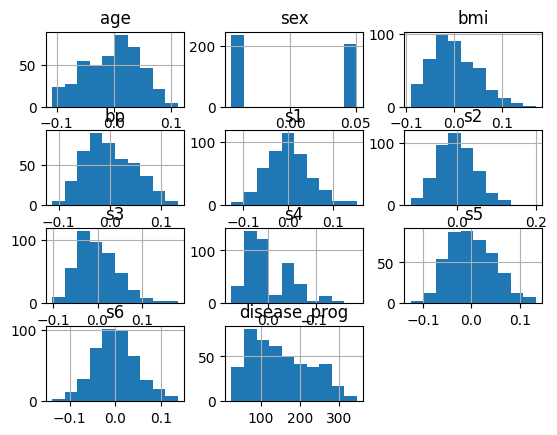

In [4]:
# I use a semicolon so as to not output the text that would otherwise be outputted with the scatterplot.
completeDF.hist();

From the histograms above, we can see that a lot of the covariates are left-skewed, meaning that the medians of the left-skewed histograms are less than their corresponding means.  

Next, we will look at the correlation matrix of the data.  A correlation matrix will compate the correlations between every variable in the dataframe.

In [5]:
completeDF.corr()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,disease_prog
age,1.000000,0.173737,0.185085,0.335428,0.260061,0.219243,-0.075181,0.203841,0.270774,0.301731,0.187889
sex,0.173737,1.000000,0.088161,0.241010,0.035277,0.142637,-0.379090,0.332115,0.149916,0.208133,0.043062
bmi,0.185085,0.088161,1.000000,0.395411,0.249777,0.261170,-0.366811,0.413807,0.446157,0.388680,0.586450
bp,0.335428,0.241010,0.395411,1.000000,0.242464,0.185548,-0.178762,0.257650,0.393480,0.390430,0.441482
s1,0.260061,0.035277,0.249777,0.242464,1.000000,0.896663,0.051519,0.542207,0.515503,0.325717,0.212022
s2,0.219243,0.142637,0.261170,0.185548,0.896663,1.000000,-0.196455,0.659817,0.318357,0.290600,0.174054
s3,-0.075181,-0.379090,-0.366811,-0.178762,0.051519,-0.196455,1.000000,-0.738493,-0.398577,-0.273697,-0.394789
s4,0.203841,0.332115,0.413807,0.257650,0.542207,0.659817,-0.738493,1.000000,0.617859,0.417212,0.430453
s5,0.270774,0.149916,0.446157,0.393480,0.515503,0.318357,-0.398577,0.617859,1.000000,0.464669,0.565883
s6,0.301731,0.208133,0.388680,0.390430,0.325717,0.290600,-0.273697,0.417212,0.464669,1.000000,0.382483


For correlations between disease_prog and the rest of the covariates, we look at either the last column or last row since correlation matricies are symmetric.

The assignment asks us to regress disease_prog against bmi, which I would say is the best choice given the correlation matrix above (at least for univariate regression).  The correlation between disease_prog and bmi is about 0.59 which is the highest correlation between disease_prog and the rest of the covariates.  It is worth noting that the correlation between disease_prog and s5 (ltg, possibly log of serum triglycerides level) is a close second with a correlation of about 0.57.

When we move on to multivariate linear regression, one important thing to note is the correlations between the covariates themselves.  One of the assumptions in linear regression is that covariates have little to no correlation between themselves.  Covariates that do have a high correlation are said to have high multicolinearity.  So covariates like s1 and s2 likely would not be included together in a multivariate regression since the correlation between the two is about 0.90.

Lastly, we can model the above correlations by looking a t a scatterplot of each column against eachother.  This could be useful in determining if a linear regression is the best model, or if we need to transform the data depending on what the scatterplot is shaped like.  For example, if a scatterplot shows that the data grows on an exponential curve instead of a linear line, then we could transform the data exponentially and do that regression instead.

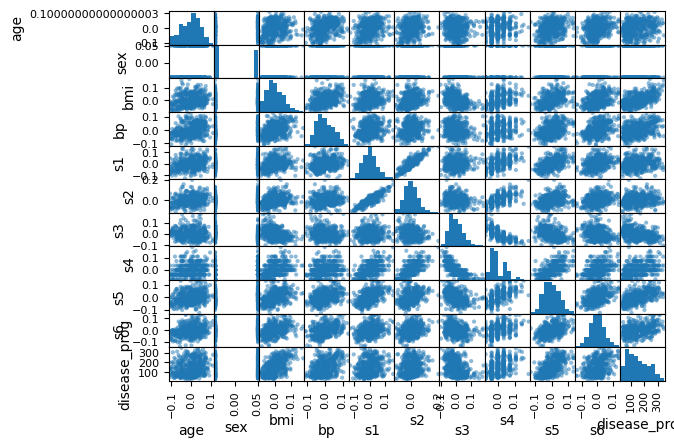

In [6]:
# I use a semicolon so as to not output the text that would otherwise be outputted with the scatterplot.
pd.plotting.scatter_matrix(completeDF);

## 4. Prepare the data to better expose the underlying data patterns to Machine Learning algorithms

In order to prepare the data, we will split the data into a training and test set.  To do this, we will take a random 25% of the observations and set them aside as a test set, and the remaining 75% will be what we train the model with.  For consistency, I will set the seed to be my student number so that the "random" choice of observations to be the test set will always be the same.

In [7]:
diabetes_XTrain, diabetes_XTest, diabetes_yTrain, diabetes_yTest = train_test_split(diabetes_X, diabetes_y,
                                                                                    test_size = 0.25,
                                                                                    random_state = 8972394) # setting the random state to be my student number

print("Dimensions of Training Dataset: ", diabetes_XTrain.shape)
print("Dimensions of Testing Dataset: ", diabetes_XTest.shape)
print("Dimensions of Complete Dataset: ", diabetes_X.shape)

Dimensions of Training Dataset:  (331, 10)
Dimensions of Testing Dataset:  (111, 10)
Dimensions of Complete Dataset:  (442, 10)


Above we can see that the sum of the rows in the training set and the testing set equal the number of rows in the complete set.

## 5. Explore many different models and short-list the best ones

As far as univatiate linear regression goes, there is not a whole lot to explore here.  In part 3 we found that BMI yields the highest correlation with disease progression, so it should be the covariate that we use when we are restricted to use only one covariate.  

In multivariate regression, you can choose different sets of covariates to determine which set builds the best model based on the model's adjusted $R^2$ value.  I do not know if Python has an equivalent function, but in R there is a function called step() that will build a baseline linear model, and will keep adding in new covariates, rebuilding the model, and checking to see if the adjusted $R^2$ value improved.  The function will keep doing this until adding new covariates does not increase the adjusted $R^2$ value.  This way, one can mathematically select the best set of covariates to use rather than keep guessing.

## 6. Fine-tune your models and combine them into a great solution

In the case of linear regression, fine-tuning a model is just solving for the slope and y-intercept that minimizes error.  It could also include finding the optimal degree of polynomial that minimizes error in the test set, but that would technically make this a multivariate regression problem since each term in the polynomial would technically count as a seperate column.  For this lab we will stick to simple linear regression, especially since we can see from the scatterplots above that the relationship between bmi and disease_prog is most likely linear anyway.

In [8]:
bmiTrain = np.array(diabetes_XTrain['bmi']).reshape(-1, 1)
linmod = LinearRegression().fit(bmiTrain, diabetes_yTrain)

slope = linmod.coef_[0][0]
yint = linmod.intercept_[0]

print("slope = ", slope)
print("y-intercept = ", yint)

slope =  979.2325092427577
y-intercept =  150.74204366201545


## 7. Present your solution

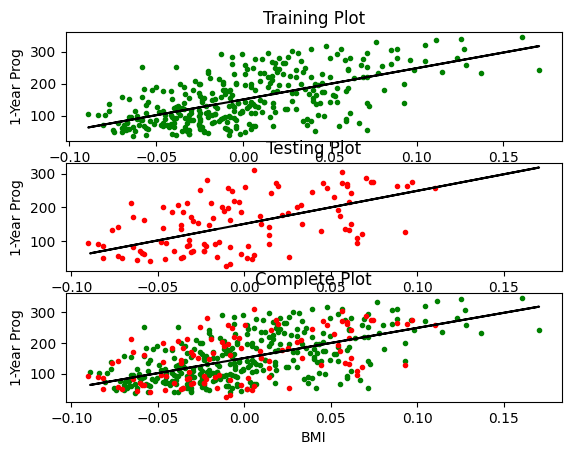

In [16]:
fig, lineplots = plt.subplots(3,1)  
xlab = "BMI"
ylab = "1-Year Prog"

# Training Plot
lineplots[0].plot(bmiTrain, diabetes_yTrain, '.', color = "green")
lineplots[0].plot(bmiTrain, linmod.predict(bmiTrain), color = "black")
lineplots[0].set_title("Training Plot")
lineplots[0].set_xlabel(xlab)
lineplots[0].set_ylabel(ylab)

# Testing Plot
lineplots[1].plot(diabetes_XTest['bmi'], diabetes_yTest, '.', color = "red")
lineplots[1].plot(bmiTrain, linmod.predict(bmiTrain), color = "black")
lineplots[1].set_title("Testing Plot")
lineplots[1].set_xlabel(xlab)
lineplots[1].set_ylabel(ylab)

# Combined Plot
lineplots[2].plot(bmiTrain, diabetes_yTrain, '.', color = "green")
lineplots[2].plot(diabetes_XTest['bmi'], diabetes_yTest, '.', color = "red")
lineplots[2].plot(bmiTrain, linmod.predict(bmiTrain), color = "black")
lineplots[2].set_title("Complete Plot")
lineplots[2].set_xlabel(xlab)
lineplots[2].set_ylabel(ylab);


In all three graphs, the black line represents the line-of-best-fit built on the training set.  Based on what we can see visually, I would say that the line models the testing data pretty well, and that this is a decent univariate model to predict disease progression based on BMI.

In [17]:
bmiTest = np.array(diabetes_XTest['bmi']).reshape(-1, 1)
bmiAll = np.array(diabetes_X['bmi']).reshape(-1, 1)

# Calculate Predictions and Residuals
diabetes_yTrainPred = linmod.predict(bmiTrain)
diabetes_yTestPred = linmod.predict(bmiTest)
diabetes_yPred = linmod.predict(bmiAll)
residualsTrain = diabetes_yTrain - diabetes_yTrainPred
residualsTest = diabetes_yTest - diabetes_yTestPred
residualsAll = diabetes_yPred - diabetes_y

# Calculate Error Metrics
rSquaredTrain = r2_score(diabetes_yTrain, diabetes_yTrainPred)
rSquaredTest = r2_score(diabetes_yTest, diabetes_yTestPred)
rSquaredAll = r2_score(diabetes_y, diabetes_yPred)
maeTrain = np.mean(abs(residualsTrain))
maeTest = np.mean(abs(residualsTest))
maeAll = np.mean(abs(residualsAll))
mseTrain = np.mean(residualsTrain**2)
mseTest = np.mean(residualsTest**2)
mseAll = np.mean(residualsAll**2)

# Outputting Metrics
print("Slope: ", round(slope, 2))
print("y-intercept: ", round(yint, 2))
print("R^2 of Training Model: ", round(rSquaredTrain, 2))
print("R^2 of Testing Model: ", round(rSquaredTest, 2))
print("R^2 of Complete Model: ", round(rSquaredAll, 2))
print("Mean-Absolute Error of Training Data: ", round(maeTrain, 2))
print("Mean-Absolute Error of Testing Data: ", round(maeTest, 2))
print("Mean-Absolute Error of All Data: ", round(maeAll, 2))
print("Mean-Squared Error of Training Data: ", round(mseTrain, 2))
print("Mean-Squared Error of Testing Data: ", round(mseTest, 2))
print("Mean-Squared Error of All Data: ", round(mseAll, 2))

Slope:  979.23
y-intercept:  150.74
R^2 of Training Model:  0.37
R^2 of Testing Model:  0.27
R^2 of Complete Model:  0.34
Mean-Absolute Error of Training Data:  49.65
Mean-Absolute Error of Testing Data:  57.28
Mean-Absolute Error of All Data:  51.57
Mean-Squared Error of Training Data:  3691.23
Mean-Squared Error of Testing Data:  4500.26
Mean-Squared Error of All Data:  3894.4


Looking at the training and testing accuracy metrics, we can see that each training metric reports a higher accuracy than the corresponding testing metric.  In the case of the $R^2$ metric, the training $R^2$ metric is greater than the testing $R^2$ metric, and for the MAE and MSE metrics, the training metric is less than the testing metric.  This is expected since the slope and y-intercept that the model calculated were selected to minimize the error based on the training data.

Lastly, a good indication that the model is a good fit (or at least the best fit it can be) is whether the residuals are normally distributed.  A non-normal distribution of residuals could mean that there is an underlying pattern in the errors of the model.

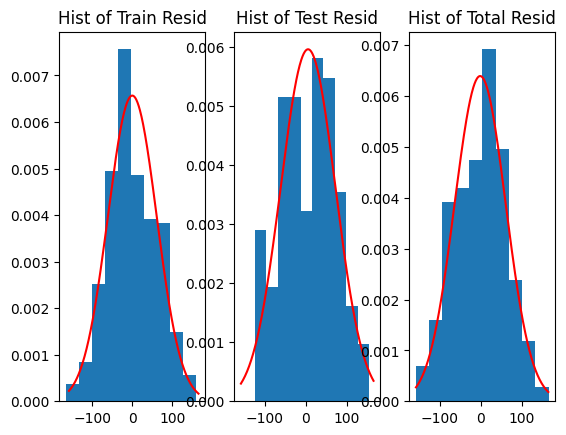

In [18]:
# Plotting results
fig, histograms = plt.subplots(1,3)
histograms[0].hist(residualsTrain, density = True)
histograms[0].set_title("Hist of Train Resid")
histograms[1].hist(residualsTest, density = True)
histograms[1].set_title("Hist of Test Resid")
histograms[2].hist(residualsAll, density = True)
histograms[2].set_title("Hist of Total Resid")

# Calculating means and standard deviations to use for histograms
residTrainMean = np.mean(residualsTrain)
residTrainSTD = np.std(residualsTrain)[0]
residTestMean = np.mean(residualsTest)
residTestSTD = np.std(residualsTest)[0]
residAllMean = np.mean(residualsAll)
residAllSTD = np.std(residualsAll)[0]

# Plotting histograms of best fit
xvals = np.arange(min(residualsAll.to_numpy())[0],
                  max(residualsAll.to_numpy())[0])
histograms[0].plot(xvals,
                   norm.pdf(xvals, residTrainMean, residTrainSTD),
                   color = "red")
histograms[1].plot(xvals,
                   norm.pdf(xvals, residTestMean, residTestSTD),
                   color = "red")
histograms[2].plot(xvals,
                   norm.pdf(xvals, residAllMean, residAllSTD),
                   color = "red");

From the histograms above, the data does not quite follow a normal distribution, but it is close.  Sometimes this can be a consequence of a low sample size since 442 is not a lot of observations, especially when we use 75% of the data to build the model and 25% of the data to test the model.

## 8. Launch, monitor, and maintain your system

In practice, maintaining and updating the model would likely be done automatically.  As more data comes in the system can take in the new data, rebuild the model with the combined new and old data, and output a new model that is updated with the new observations.  This can be programmed to be done automatically based on the company's needs and resources.  For example, the company can collect the data on diabetes as new patients come in and store the data on a server somewhere.  Then every month, the program can run to take in the updated data and rebuild the model.

Another thing that could be done is that the old model can be treated as a training set and the new data can be treated as a test set before combining the data.  This way, we could measure potential inconsistencies in the new data that could highlight some kind of change that happened during that month.